In [160]:
import numpy as np
import scipy.stats
import pandas
import matplotlib.pyplot as plt
import matplotlib.patches
import imageio
from IPython.display import clear_output

In [161]:
map_image = imageio.imread('https://www.cl.cam.ac.uk/teaching/2122/DataSci/data/voronoi-map-goal-16000-shaded.png')
localization = pandas.read_csv('https://www.cl.cam.ac.uk/teaching/2122/DataSci/data/localization.csv')

In [162]:
localization.head()

,id,t,x,y,r,g,b
0,0,0,NaN,NaN,0.276988,0.491407,0.424521
1,0,1,NaN,NaN,0.374629,0.478715,0.432729
2,0,2,NaN,NaN,0.197875,0.370261,0.563303
3,0,3,NaN,NaN,0.176730,0.282580,0.474301
4,0,4,NaN,NaN,0.154155,0.348189,0.536211


In [163]:
localization.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      2500 non-null   int64  
 1   t       2500 non-null   int64  
 2   x       2000 non-null   float64
 3   y       2000 non-null   float64
 4   r       2500 non-null   float64
 5   g       2500 non-null   float64
 6   b       2500 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 136.8 KB


In [164]:
localization.describe()

,id,t,x,y,r,g,b
count,2500.000000,2500.000000,2000.000000,2000.000000,2500.000000,2500.000000,2500.000000
mean,2.000000,249.500000,254.582287,221.967676,0.405393,0.465595,0.452825
std,1.414496,144.366155,170.187401,130.998861,0.156404,0.173620,0.093133
min,0.000000,0.000000,0.000000,0.000000,0.115416,0.102951,0.144260
25%,1.000000,124.750000,58.825559,141.579808,0.281215,0.300538,0.397683
50%,2.000000,249.500000,305.804590,211.802482,0.369794,0.463892,0.461038
75%,3.000000,374.250000,381.990830,341.213665,0.512877,0.615944,0.510734
max,4.000000,499.000000,559.564002,471.678909,0.978263,0.996107,0.953408


In [165]:
localization.sort_values(['id','t'], inplace=True)
# Pull out observations for the animal we want to track: id = 0
observations = localization.loc[localization.id==0, ['r','g','b']].values

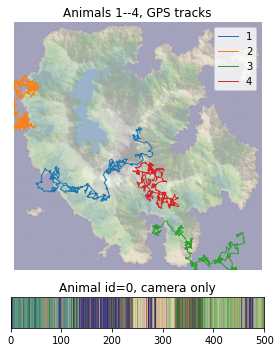

In [166]:
df = localization

fig,(ax,ax2) = plt.subplots(2,1, figsize=(4,5), gridspec_kw={'height_ratios':[4,.5]})
ax.imshow(map_image.transpose(1,0,2), alpha=.5) # ax.imshow interprets as (y,x) while map_image has format (x,y), so need to transpose beforehand
w,h = map_image.shape[:2]
ax.set_xlim([0,w])
ax.set_ylim([0,h])

for i in range(1,5):
    ax.plot(df.loc[df.id==i,'x'].values, df.loc[df.id==i,'y'].values, lw=1, label=i)
ax.axis('off')
ax.legend()
ax.set_title('Animals 1--4, GPS tracks')

ax2.bar(np.arange(len(observations)), np.ones(len(observations)), color=observations, width=2)
ax2.set_xlim([0,len(observations)])
ax2.set_yticks([])
ax2.set_title('Animal id=0, camera only')

plt.tight_layout()
plt.show()


### Empirical approximation of $X_0$: location $X_0$ is uniformally distributed

In [167]:
W,H = map_image.shape[:2]
M = num_particles = 2000

# M * 3 array, one row per particle, columns are x, y coordinate and weight w
# in prior uniform distribution, the weight is w = 1/M
# Empirical representation of the distribution of X0
δ0 = np.column_stack([np.random.uniform(0,W-1,size=M), np.random.uniform(0,H-1,size=M), np.ones(M)/M])

In [168]:
# a handy function to visualise the particles
def show_particles(particles, ax=None, s=1, c='red', alpha=.5):
    # Plot an array of particles, with size proportional to weight.
    # (Scale up the sizes by setting s larger.)
    if ax is None:
        fig,ax = plt.subplots(figsize=(2.5,2.5))
    ax.imshow(map_image.transpose(1,0,2), alpha=alpha, origin='lower')
    w,h = map_image.shape[:2]
    ax.set_xlim([0,w])
    ax.set_ylim([0,h])
    w = particles[:,2]
    ax.scatter(particles[:,0],particles[:,1], s=w/np.sum(w)*s, color=c)
    ax.axis('off')

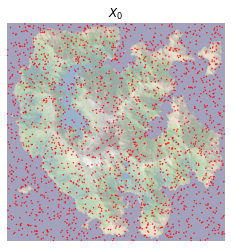

In [169]:
fig,ax = plt.subplots(figsize=(4,4))
show_particles(δ0, s=400, ax=ax)
ax.set_title('$X_0$')
plt.show()

### Empirical approximation of $(X_0|y_0)$: updated weights

In [170]:
observations

array([[0.27698774, 0.4914071 , 0.42452084],
       [0.37462916, 0.47871462, 0.43272893],
       [0.19787482, 0.37026117, 0.56330338],
       ...,
       [0.51219044, 0.63726831, 0.43869665],
       [0.38540844, 0.66883156, 0.41029473],
       [0.4396261 , 0.57064232, 0.4042017 ]])

In [171]:
y0 = observations[0]
y0

array([0.27698774, 0.4914071 , 0.42452084])

In [172]:
# a handy function to extract the average colour of a patch
def patch(im, xy, size=3):
    s = (size-1) / 2
    nx,ny = np.meshgrid(np.arange(-s,s+1), np.arange(-s,s+1))
    nx,ny = np.stack([nx,ny], axis=0).reshape((2,-1))
    neighbourhood = np.row_stack([nx,ny])
    w,h = im.shape[:2]
    neighbours = neighbourhood + np.array(xy).reshape(-1,1)
    neighbours = nx,ny = np.round(neighbours).astype(int)
    nx,ny = neighbours[:, (nx>=0) & (nx<w) & (ny>=0) & (ny<h)]
    patch = im[nx,ny,:3]
    return np.mean(patch, axis=0)/255

In [173]:
loc = δ0[0,:2]
print(f"First particle is at {loc}")

col = patch(map_image, loc, size=3)
print(f"Map terrain around this particle: rgb = {col}")

First particle is at [516.348127   405.65857171]
Map terrain around this particle: rgb = [0.27712418 0.27712418 0.48191721]


### Task 1

In [174]:
def find_mean_var(im, xy, size=3):
    s = (size-1) / 2
    nx,ny = np.meshgrid(np.arange(-s,s+1), np.arange(-s,s+1))
    nx,ny = np.stack([nx,ny], axis=0).reshape((2,-1))
    neighbourhood = np.row_stack([nx,ny])
    w,h = im.shape[:2]
    neighbours = neighbourhood + np.array(xy).reshape(-1,1)
    neighbours = nx,ny = np.round(neighbours).astype(int)
    nx,ny = neighbours[:, (nx>=0) & (nx<w) & (ny>=0) & (ny<h)]
    patch = im[nx,ny,:3]
    patch = patch / 255
    𝜇 = np.mean(patch, axis=0)
    𝜎_2 = np.sum((patch-𝜇) ** 2, axis=0)/len(patch)
    return 𝜇, 𝜎_2

In [175]:
# pr(y|loc): probability of observing y if the true location is loc
def pr(y, loc):
    # assume R, G, B independent normal distribution
    # mean is the average colour around a location
    𝜇, 𝜎_2 = find_mean_var(map_image, loc, size=3)
    𝜇_r, 𝜇_g, 𝜇_b = 𝜇
    𝜎_2r, 𝜎_2g, 𝜎_2b = 𝜎_2 * 20 # TODO: why times 20?
    r,g,b = y
    return scipy.stats.norm.pdf(r,loc=𝜇_r, scale=𝜎_2r) * scipy.stats.norm.pdf(g,loc=𝜇_g, scale=𝜎_2g) * scipy.stats.norm.pdf(b,loc=𝜇_b, scale=𝜎_2b)

In [176]:
# Sanity check
y0 = observations[0]
loc = δ0[0,:2]
w = pr(y0, loc)
import numbers
assert isinstance(w, numbers.Number) and w>=0

In [177]:
y0 = observations[0]
w = np.array([pr(y0, (x,y)) for x,y,_ in δ0])
π0 = np.copy(δ0)
π0[:,2] = w / sum(w)

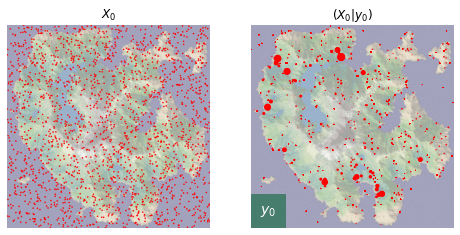

In [178]:
fig,(axδ,axπ) = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)
show_particles(δ0, ax=axδ, s=600)
show_particles(π0, ax=axπ, s=600)
axπ.add_patch(matplotlib.patches.Rectangle((0,0),100,100,color=y0))
axπ.text(50,50,'$y_0$', c='white', ha='center', va='center', fontsize=14)
axδ.set_title('$X_0$')
axπ.set_title('$(X_0|y_0)$')
plt.show()

### Task 2

In [179]:
def walk(loc):
    # Simulate animal's movement in one timestamp
    # Animal chooses a direction uniformaly in the range [0,2π), 
    # then chooses a random distance Exp(5), walk less as time passed by
    # Truncate the position to ensure it lies on the map
    direction = np.random.uniform(low=0, high=2*np.pi)
    radius = np.random.exponential(scale=5)
    x, y = loc
    x += radius * np.cos(direction)
    y += radius * np.sin(direction)
    x = min(max(0, x), W-1)
    y = min(max(0, y), H-1)
    return x,y

In [180]:
# Sanity check
loc = π0[0,:2]
loc2 = walk(loc)
assert len(loc2)==2 and isinstance(loc2[0], numbers.Number) and isinstance(loc2[1], numbers.Number)
assert loc2[0]>=0 and loc2[0]<=W-1 and loc2[1]>=0 and loc2[1]<=H-1

In [181]:
δ1 = np.copy(π0)
for i in range(len(δ1)):
    δ1[i,:2] = walk(δ1[i,:2])

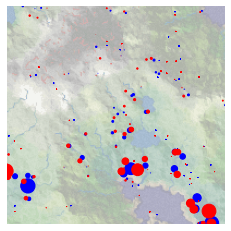

In [182]:
fig,ax = plt.subplots(figsize=(4,4))
show_particles(π0, ax=ax, s=4000, c='blue', alpha=.25)
show_particles(δ1, ax=ax, s=4000, c='red', alpha=.25)
ax.set_xlim([200,400])
ax.set_ylim([100,300])
plt.show()

### Task 3

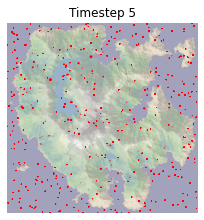

In [183]:
# apply the two update steps iteratively, updating the sample based on successive observations
particles = np.copy(π0)

for n,obs in enumerate(observations[:5]):
    # Compute δ, the locations after a movement step
    for i in range(num_particles):
        particles[i,:2] = walk(particles[i,:2])
    # Compute π, the posterior after observing y
    w = np.array([pr(obs, (px,py)) for px,py,_ in particles])
    particles[:,2] = w / sum(w)

    # Plot the current particles
    fig,ax = plt.subplots(figsize=(3.5,3.5))
    show_particles(particles, ax, s=20)
    ax.set_title(f"Timestep {n+1}")
    plt.show()
    clear_output(wait=True)

In [184]:
def get_weights(iter_num):
  # apply the two update steps iteratively, updating the sample based on successive observations
  particles = np.copy(π0)

  for n,obs in enumerate(observations[:iter_num]):
      # Compute δ, the locations after a movement step
      for i in range(num_particles):
          particles[i,:2] = walk(particles[i,:2])
      # Compute π, the posterior after observing y
      w = np.array([pr(obs, (px,py)) for px,py,_ in particles])
      particles[:,2] = w / np.sum(w)
  return particles

/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:1740: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


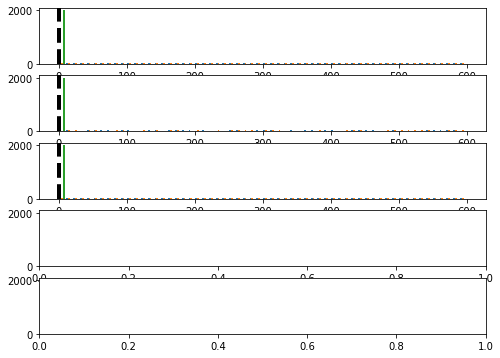

In [186]:
fig,axes = plt.subplots(5,1, figsize=(8,6), sharey=True)
for n,ax in zip([0,1,5],axes):
    # w is the appropriate weights
    w = get_weights(n)
    ax.hist(w, bins=60)
    ax.axvline(x=1/len(particles), color='black', linewidth=4, linestyle='dashed')
plt.show()

### Task 4

In [187]:
# delete the lowest-weighted 20% of the particles
# take the highest-weighted 20% of the particles and split them into two 
#    -> create a duplicate at the same location, give two locations the same half weight of original particle
#    -> two versions would diverge in the future
def prune_spawn(particles):
    sorted_particles = particles[np.argsort(particles[:, 2])]
    low_weight_portion_ub = int(len(sorted_particles) * 0.2)
    high_weight_portion_lb = int(len(sorted_particles)*0.8)
    sorted_particles[high_weight_portion_lb:, 2] /= 2
    high_weight_particles = sorted_particles[high_weight_portion_lb:]
    sorted_particles = sorted_particles[low_weight_portion_ub:]
    sorted_particles = np.vstack((sorted_particles, high_weight_particles))
    return sorted_particles

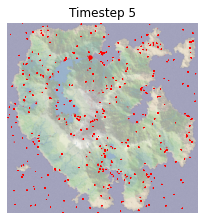

In [189]:
particles = np.copy(π0)

for n,obs in enumerate(observations[:100]):
    # Compute δ, the locations after a movement step
    for i in range(num_particles):
        particles[i,:2] = walk(particles[i,:2])
    # Compute π, the posterior after observing y
    w = np.array([pr(obs, (px,py)) for px,py,_ in particles])
    particles[:,2] = w / sum(w)
    # Prune/spawn
    particles = prune_spawn(particles)
    # Plot the current particles
    fig,ax = plt.subplots(figsize=(3.5,3.5))
    show_particles(particles, ax, s=20)
    ax.set_title(f"Timestep {n+1}")
    plt.show()
    clear_output(wait=True)

### Task 5

In [190]:
def get_matrix():
  particles = np.copy(π0)

  for n,obs in enumerate(observations[:100]):
      # Compute δ, the locations after a movement step
      for i in range(num_particles):
          particles[i,:2] = walk(particles[i,:2])
      # Compute π, the posterior after observing y
      w = np.array([pr(obs, (px,py)) for px,py,_ in particles])
      particles[:,2] = w / sum(w)
      # Prune/spawn
      particles = prune_spawn(particles)
  map_array = [[0 for j in range(0,H)] for i in range(W)]
  locx, locy = particles[:,0].astype(int), particles[:,1].astype(int)
  for x,y,w in zip(locx, locy, particles[:,2]):
    map_array[x][y] += w
  return map_array / np.sum(map_array)

In [ ]:
p = get_matrix() # w*h matrix

/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:1740: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [ ]:
np.max(p), np.min(p), np.sum(p), len(p > 0)

In [ ]:
hp = np.hstack(p)
fig, ax = plt.subplots()
ax.plot(np.arange(W * H), hp)
ax.set_xlabel('pixel index')
ax.set_ylabel('probability')
plt.savefig("index-probability.png", dpi=100)
plt.show()

In [ ]:
# Save heatmap as png
fig,ax = plt.subplots(figsize=(W/100, H/100), dpi=100)
ax.imshow(p.transpose(1,0), origin='lower', cmap='gray', vmin=0, interpolation='none')
ax.set_xlim([0,W])
ax.set_ylim([0,H])
plt.axis('off')
plt.savefig("myprediction.png", dpi=100)
plt.show()